In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.initializers import *
from IPython.display import clear_output

mpl.style.use('classic')
mpl.style.use('seaborn')

# Инициализация весов

При создании и обучении нейронных сетей крайне важно соответствующим образом инициализировать веса, чтобы обеспечить высокую точность модели. Если веса инициализированы неправильно, это может привести к проблеме исчезающего градиента или проблеме возрастающего градиента. Следовательно, выбор соответствующей стратегии инициализации веса имеет решающее значение при обучении моделей DL. Рассмотрим некоторые методы и начнем с тривиального решения:

<hr style="border:1px solid">

### **Метод 1**: Инициализация всех весов константой

**Проблема**: в данном случае градиент по всем весам будет одинаковым, как и обновление весов. Все нейроны будут учить одно и то же, а значит слой будет эквивалентен одному нейрону.

**Вывод**: инициализировать весы надо различными значениями

В пакете Keras есть реализация данного инициализатора:

```python
tf.keras.initializers.Constant(1.0) # Инициализирует тензор единицами
```

<hr style="border:1px solid">

### **Метод 2**: Инициализировать распределением с параметрами мат. ожидания $\mu = 0$ и маленькой дисперсией

В качестве распределения мы можем взять нормальное (Гауссовское) или непрерывное распределение.

Маленькая дисперсия нужна, чтобы не получить огромные градиенты за большие изначальные ошибки в предсказании.

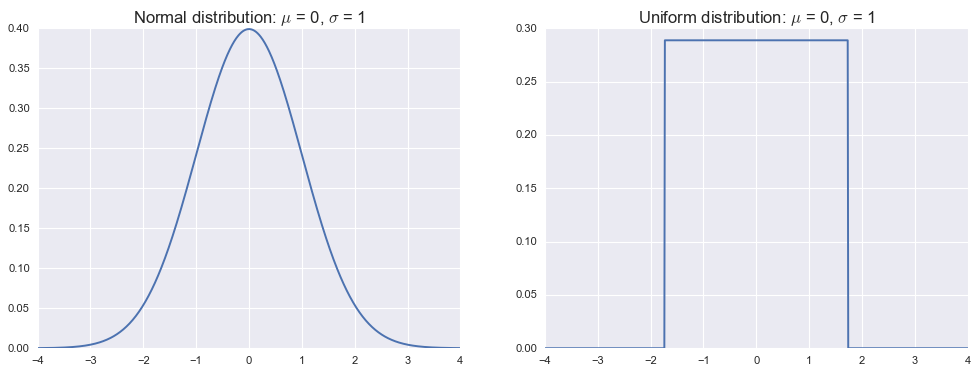

In [2]:
# Визуализация нормального и равномерного распределений с нулевым мат. ожиданием и единичной дисперсией
x  = np.arange(-4, 4.01, 0.01)
y1 = np.exp(-np.square(x) / 2) / np.sqrt(2 * np.pi) 
y2 = np.full_like(x, 1/(2*np.sqrt(3))) * ((-np.sqrt(3) <= x) * (x <= np.sqrt(3)))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title("Normal distribution: $\mu$ = 0, $\sigma$ = 1", size=15)
ax[0].plot(x, y1)
ax[1].set_title("Uniform distribution: $\mu$ = 0, $\sigma$ = 1", size=15)
ax[1].plot(x, y2)
plt.show()

**Преимущества**: нейроны обучаются по-разному, что сильно увеличивает обобщающую способность сети

**Проблема**: нормальное или непрерывное распределение так же не гарантирует проблему затухающих и взрывающихся градиентов

**Вывод**: требуется формализовать проблему с градиентами и решить её

В пакете Keras:

```python
# Инициализирует тензор нормальным распределением с нулевым мат. ожиданием и единичной дисперсией
tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0) 
```

<hr style="border:1px solid">

### **Метод 3**: Выведем оптимальное значение для показателя дисперсии

Рассмотрим линейное преобразование:

$$ y = w^Tx+b = \sum_{i=1}^{n_{in}}{(w_ix_i)} + b = \sum_{i=1}^{n_{in}}{(y_i)} + b $$

Если принять $b = 0$ и рассмотреть дисперсию преобразования - получим:

$$ D[y_i] = D[w_ix_i] \overset{\text{(дисперсия произведения)}}{=} M[w_i]^2D[x_i] + M[x_i]^2D[w_i] + D[w_i]D[x_i] $$ 

Тут $M[x]$ - мат. ожидание величины x, а $D[x]$ - дисперсия величины x.

Так как рассматриваемые параметры (веса) - настраиваемые, а входные значения мы можем отнормировать в начале обучения, то мы можем добится нулевых мат. ожиданий: $M[w_i] = 0; M[x_i] = 0$ и тогда получается:

$$ D[y_i] = D[w_i]D[x_i] $$

Данное состояние верно для первого слоя, однако не гарантируется, что при проходе через функцию активации мат. ожидание будет сохраняться нулю.

<hr style="border:1px solid">

**Заметка**: При использовании симметричной функции активации (sigmoid, tanh) мат. ожидание будет сохраняться нулевым при нулевом мат. ожидании предыдущего слоя.

**Доказательство**: Пусть $x = f(y_{prev})$, где $f$ - симметричная функция активации. $y_{prev} = w_{prev}^Tx_{prev}$, причем $M[x_{prev_i}] = 0; M[w_{prev_i}] = 0$.

1. $M[y_{prev_i}] = M[w_{prev_i}x_{prev_i}] = M[w_{prev_i}]M[x_{prev_i}] = 0$

2. $M[y_{prev}] = M\left[\sum_{i=1}^{n_{in}}{y_{prev_i}}\right] = \sum_{i=1}^{n_{in}}{\left[M[y_{prev_i}]\right]} = 0$

3. $M[x] = M[f(y_{prev})] = 0$

<hr style="border:1px solid">

Теперь найдем дисперсию выходных значений, т.к. все веса из одинакового распределения а входы отнормированы, получим:

$$ D[y] = D\left[\sum_{i=1}^{n_{in}}{y_i}\right] = \sum_{i=1}^{n_{in}}{D\left[w_ix_i\right]} = n_{in}D[w_i]D[x_i] $$

В итоге получается, что дисперсия выходных значений линейно зависит от дисперсии входных данных с коэффициентом $n_{in}D[w_i]$. Отсюда можно сделать такие выводы:
1. При $n_{in}D[w_i]$ > 1 дисперсия выходных значений будет увеличиваться с каждым слоем. Это может привести к ошибкам и насыщению функции активации. 
2. При $n_{in}D[w_i]$ < 1 дисперсия выходных значений будет уменьшаться с каждым слоем, что может привести поведение модели к линейному, а это негативно скажется на обучении
3. При $n_{in}D[w_i]$ = 1 дисперсия выходных значений не будет зависеть от начальных значений весов, именно такого поведения мы и хотим добиться.

Таким образом следует выбрать распределение с дисперсией $D[w_i] = \frac{1}{n_{in}}$.

**Преимущества**: начальные значения весов не вносят вклад в дисперсию выходных значений, что позволяет решить проблему взрывающихся и затухающих градиентов

**Проблема**: данные формулы хорошо работают только если входные и выходные размерности совпадают

<hr style="border:1px solid">

### **Метод 4**: Xavier (Glorot) initialization

В предыдущем методе мы учли сохранение дисперсий при прямом проходе, при обратном проходе в ходе *back propagation* формула для оптимальной дисперсии будет такая: $D[w_{i}] = \frac{1}{n_{out}}$. Получается два уравнения:

1. Прямой проход: $$n_{in}D[w_i] = 1$$
2. Обратный проход: $$n_{out}D[w_i] = 1$$

Если размерности совпадают, то система разрешима, иначе условия не выполняются одновременно. В ходе своей [статьи](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) Ксавье и Ёшуа предложили компромисс - среднее гармоническое:

$$ D[w_i] = \frac{2}{n_{in} + n_{out}} $$

Отсюда мы можем вывести значения дисперсии для нормального и непрерывного распределений:

* Для непрерывного распределения $w_i \sim U([a; b])$, где $a = -b$:

$$ M[w_i] = 0 $$
$$ D[w_i] = \frac{(b-a)^2}{12} = \frac{b^2}{3} = \frac{2}{n_{in} + n_{out}} $$
$$ b = \sqrt{\frac{6}{n_{in} + n_{out}}} $$

Следовательно веса будут иметь распределение: $w_i \sim U([-\sqrt{\frac{6}{n_{in} + n_{out}}}; \sqrt{\frac{6}{n_{in} + n_{out}}}])$

* Для нормального распределения $w_i \sim N([0; \sqrt{\frac{2}{n_{in} + n_{out}}}])$:

В пакете Keras уже есть реализация инициализатора Glorot.

```python
tf.keras.initializers.GlorotNormal()
tf.keras.initializers.GlorotUniform()
```

Пример использования:

In [3]:
initializer = GlorotNormal()
W = initializer(shape=(5, 10))

Вернет случайный тензор размерности $5 \times 10$.

Также можно убедиться в согласованности с выкладками:

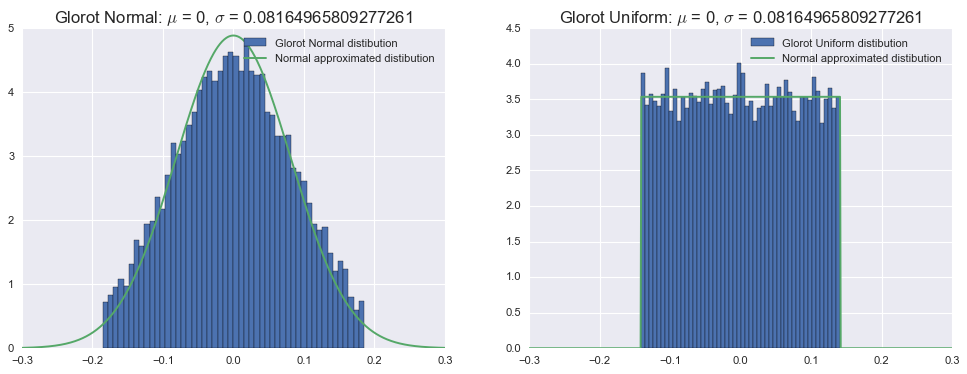

In [4]:
# Задает нормальное распределение с заданными параметрами
def NormalKernel(mean, std):
    def Kernel(x):
        return np.exp(-np.square((x - mean) / std) / 2) / np.sqrt(2 * np.pi) / std
    return Kernel

# Задает равномерное распределение с заданными параметрами
def UniformKernel(a, b):
    def Kernel(x):
        return np.full_like(x, 1/(b - a)) * ((a <= x) * (x <= b))
    return Kernel

# Отрисовка заданного распределения и гистаграммы заданного инициализатора
def PrintDistribution(name, kernel, initializer, n_in, n_out, ax):
    tensor = initializer(shape=(n_in, n_out))
    y = tensor.numpy().flatten()
    x  = np.arange(-0.3, 0.301, 0.001)
    
    ax.hist(y, density = True, bins=50, label=f"{name} distibution")
    ax.set_title(f"{name}: $\mu$ = 0, $\sigma$ = {sigma}", size=15)
    ax.plot(x, kernel(x), label="Normal approximated distibution")
    ax.legend()

n_in, n_out = 100, 200                         # задание входных и выходных размерностей
mu, sigma = 0, np.sqrt(2 / (n_in + n_out))     # параметры для нормального распределения по Глороту
a, b = -np.sqrt(3) * sigma, np.sqrt(3) * sigma # параметры для равномерного распределения по Глороту

fig, ax = plt.subplots(1, 2, figsize=(15,5))

PrintDistribution("Glorot Normal", NormalKernel(mu, sigma), GlorotNormal(), n_in, n_out, ax[0])
PrintDistribution("Glorot Uniform", UniformKernel(a, b), GlorotUniform(), n_in, n_out, ax[1])

plt.show()

Также можно продемонстрировать, что будет происходить на первой итерации обучения при прямом проходе при различных инициализаторах весов.

In [5]:
# Отрисовка гистаграммы распределения выходных значений тензора с заданным инициализатором и функцией активации
def Plot(name, initializers, ax, activation="tanh", stddev=0.15):
    initializer = initializers[name]
    shape = (5000, 4000)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape[0]),
        tf.keras.layers.Dense(shape[1], activation=activation, kernel_initializer=initializer[0], use_bias=False),
        tf.keras.layers.Dense(shape[1], activation=activation, kernel_initializer=initializer[1], use_bias=False),
    ])
    
    weights_std = float(tf.math.reduce_std(model.get_layer(index=0).weights)) # дисперсия весов после инициализации
    
    # входной тензор с нулевым мат. ожиданием и заданной дисперсией
    tensor = tf.keras.initializers.RandomNormal(mean=0.0, stddev=stddev)(shape=(1, shape[0]))

    out_tensor = model(tensor)
    out_tensor_mean = tf.math.reduce_mean(out_tensor)
    out_tensor_std = tf.math.reduce_std(out_tensor)
    
    y = out_tensor.numpy().flatten()
    x = np.arange(y.min(), y.max(), 0.01)

    ax.set_title(f"{name}\nMean: {out_tensor_mean:.4f} Std: {out_tensor_std:.4f}")
    ax.hist(y, density = True, bins=len(y) // 50, label="Real distribution")
    ax.plot(x, NormalKernel(out_tensor_mean, out_tensor_std)(x), label="Normal approximated distribution")
    ax.plot(x, NormalKernel(0.0, np.sqrt(shape[0]) * weights_std * stddev)(x), label="Desired distribution")
    ax.legend(loc='best')

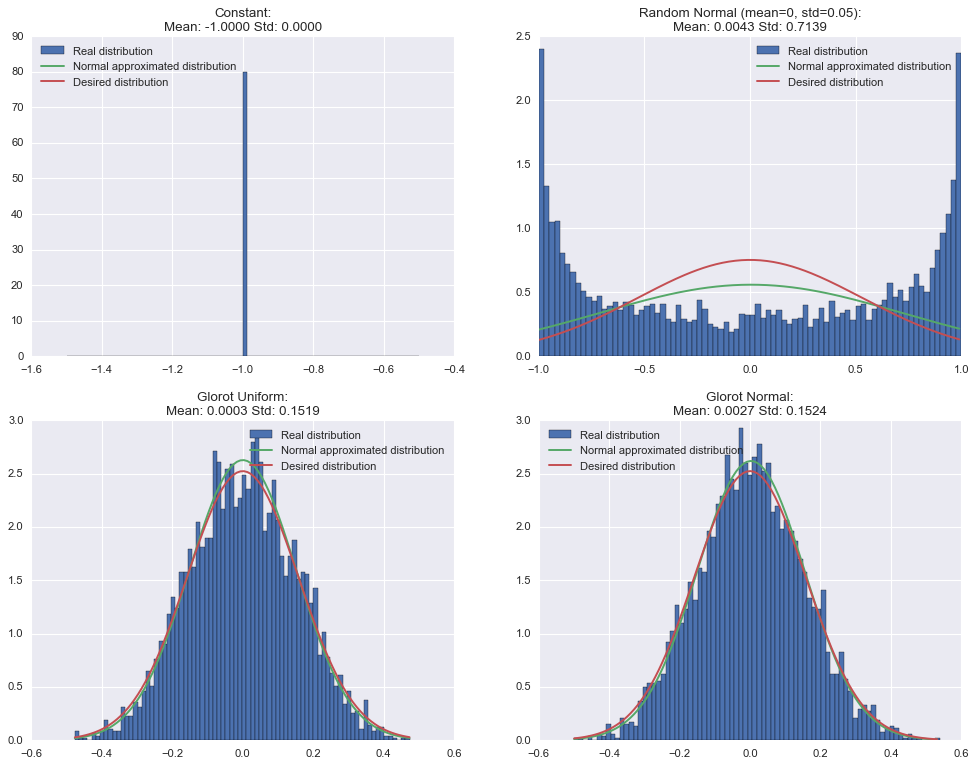

In [16]:
# Отрисовка распределения выходных значений при симметричной функции активации и различными инициализаторами
fig, ax = plt.subplots(2, 2, figsize=(15,11))

initializers = {
    "Constant:": [Constant(3.0), Constant(2.0)],
    "Random Normal (mean=0, std=0.05):": [RandomNormal(mean=0.0, stddev=0.05), RandomNormal(mean=0.0, stddev=0.05)],
    "Glorot Uniform:": [GlorotUniform(), GlorotUniform()],
    "Glorot Normal:": [GlorotNormal(), GlorotNormal()],
}

Plot("Constant:", initializers, ax[0, 0])
Plot("Random Normal (mean=0, std=0.05):", initializers, ax[0, 1])
Plot("Glorot Uniform:", initializers, ax[1, 0])
Plot("Glorot Normal:", initializers, ax[1, 1])

plt.show()

По данным графикам можно увидеть, что при инициализации весов нормальным распределением с дисперсией $D[w_i]=0.1$ значения переходят в область насыщения, стремясь к -1 и 1. В случае же Glorot инициализации изначальное распределение сохраняется нормальным с дисперсией близкой к $0.15$, и выходные значения не уходят в область насыщения. То же самое нельзя сказать в случае, когда наша функция активации не симметрична. К примеру с функцией ReLu:

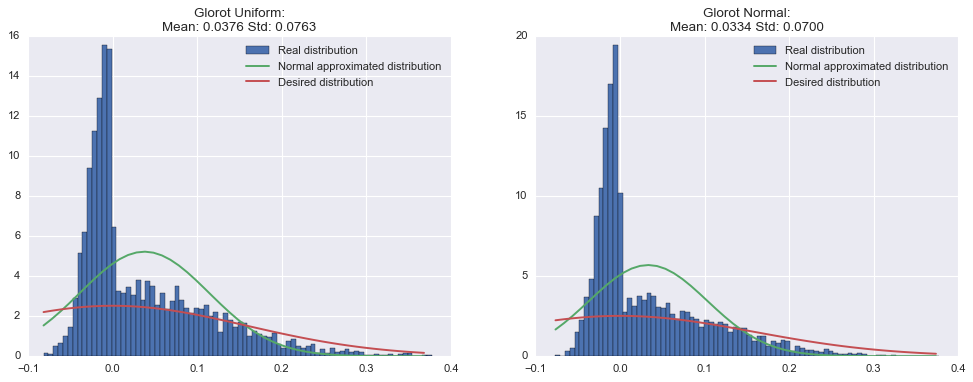

In [7]:
# Отрисовка распределения выходных значений при несимметричной функции активации
fig, ax = plt.subplots(1, 2, figsize=(15,5))

initializers = {
    "Glorot Uniform:": [GlorotUniform(), GlorotUniform()],
    "Glorot Normal:": [GlorotNormal(), GlorotNormal()],
}

Plot("Glorot Uniform:", initializers, ax[0], activation="leaky_relu")
Plot("Glorot Normal:", initializers, ax[1], activation="leaky_relu")

plt.show()

<hr style="border:1px solid">

### **Метод 5**: Kaiming He initialization

Как мы увидели ранее, Glorot инициализация отлично подходит для симметричных функций активации, однако это не работает с функциями типа ReLu. В статье про классификацию ImageNet лучше человека Каймин Хе предложили способ инициализации весов для ReLu подобных функций активации. Формулы выводятся аналогично Glorot, в итоге мы получаем уравнения:


1. Прямой проход: $$\frac{n_{in}D[w_i]}{2} = 1$$
2. Обратный проход: $$\frac{n_{out}D[w_i]}{2} = 1$$

В данном случае принято брать не средне-гармоническое, а одно из двух вариантов. 
К примеру $D[w_i] = \frac{2}{n_{in}}$:

* Для непрерывного распределения $w_i \sim U([a; b])$, где $a = -b$:

$$ M[w_i] = 0 $$
$$ D[w_i] = \frac{(b-a)^2}{12} = \frac{b^2}{3} = \frac{2}{n_{in}} $$
$$ b = \sqrt{\frac{6}{n_{in}}} $$

Следовательно веса будут иметь распределение: $w_i \sim U([-\sqrt{\frac{6}{n_{in}}}; \sqrt{\frac{6}{n_{in}}}])$

* Для нормального распределения $w_i \sim N([0; \sqrt{\frac{2}{n_{in}}}])$:

В пакете Keras:

```python
tf.keras.initializers.HeUniform()
tf.keras.initializers.HeNormal()
```

Пример:

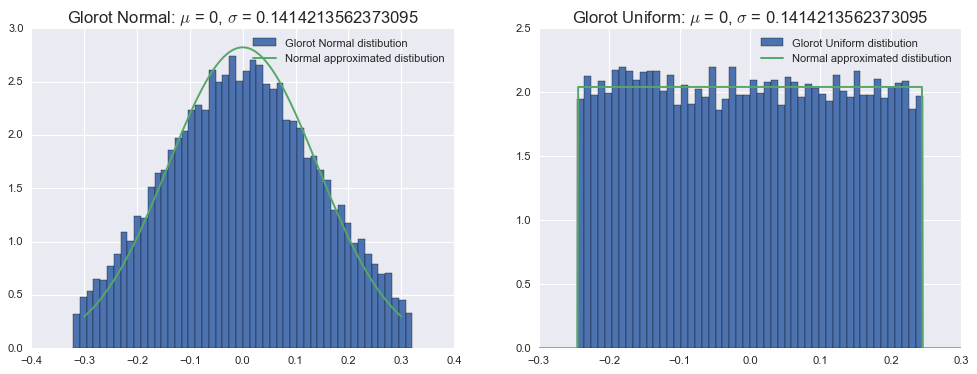

In [8]:
n_in, n_out = 100, 200                         # задание входных и выходных размерностей
mu, sigma = 0, np.sqrt(2 / (n_in))             # параметры для нормального распределения по Каймину
a, b = -np.sqrt(3) * sigma, np.sqrt(3) * sigma # параметры для равномерного распределения по Каймину

fig, ax = plt.subplots(1, 2, figsize=(15,5))

PrintDistribution("Glorot Normal", NormalKernel(mu, sigma), HeNormal(), n_in, n_out, ax[0])
PrintDistribution("Glorot Uniform", UniformKernel(a, b), HeUniform(), n_in, n_out, ax[1])

plt.show()

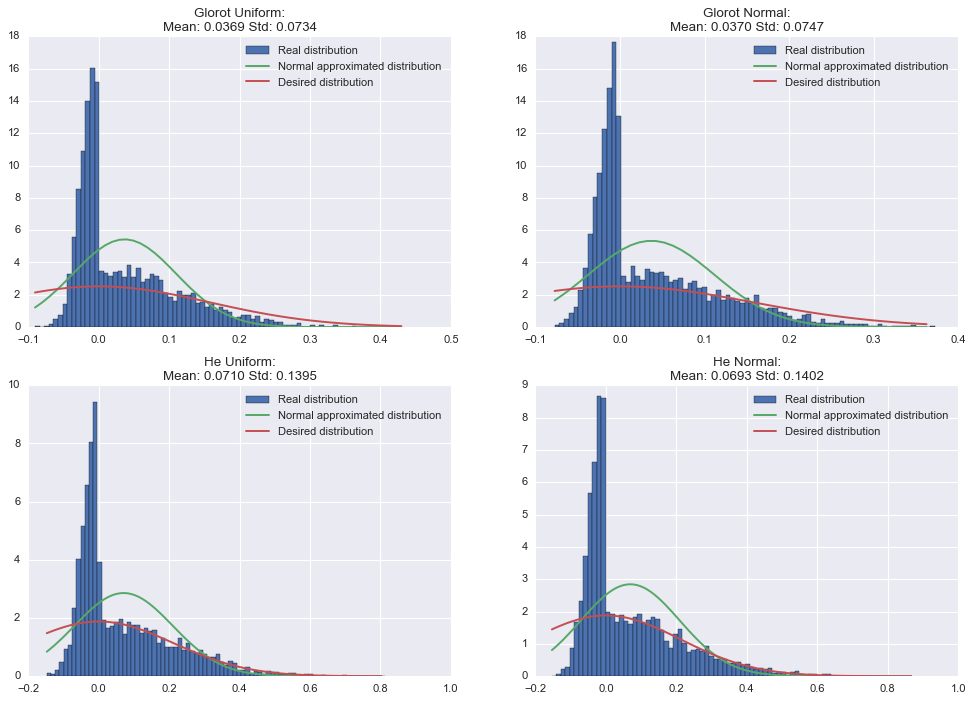

In [9]:
# Отрисовка распределения выходных значений при инициализаторах Глорота и Каймина
fig, ax = plt.subplots(2, 2, figsize=(15,10))

initializers = {
    "He Uniform:": [HeUniform(), HeUniform()],
    "He Normal:": [HeNormal(), HeNormal()],
    "Glorot Uniform:": [GlorotUniform(), GlorotUniform()],
    "Glorot Normal:": [GlorotNormal(), GlorotNormal()],
}

Plot("Glorot Uniform:", initializers, ax[0, 0], activation="leaky_relu")
Plot("Glorot Normal:", initializers, ax[0, 1], activation="leaky_relu")
Plot("He Uniform:", initializers, ax[1, 0], activation="leaky_relu")
Plot("He Normal:", initializers, ax[1, 1], activation="leaky_relu")

plt.show()

Из результатов видно, что хотя мы и не можем гарантировать нулевое мат. ожидание на входах, мы можем попытаться контролировать дисперсию между входами ReLu, и при He инициализации дисперсия ближе к начальному распределению входов, нежели чем при Glorot.

<hr style="border:1px solid">

## Классификация MNIST 



In [10]:
# Загрузка и нормирование датасета
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255.0
x_train = x_train - x_train.mean()
y_train = tf.keras.utils.to_categorical(y_train, 10)

In [11]:
# Callback для подсчета потерь и точности на каждом батче
class BCP(tf.keras.callbacks.Callback):

    def __init__(self):
        super(BCP,self).__init__()

    def on_train_begin(self, logs=None):
        self.model.history.history["batch_loss"] = []
        self.model.history.history["batch_accuracy"] = []

    def on_train_batch_end(self, batch, logs=None):
        self.model.history.history["batch_loss"].append(logs.get('loss'))
        self.model.history.history["batch_accuracy"].append(logs.get('accuracy'))

# Создание модели с заданными инициализатором и функцией активации
def CreateModel(initializer, activation, name="default"):      
    model = tf.keras.Sequential([
        tf.keras.layers.Input((28, 28, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(14*14, kernel_initializer=initializer, activation=activation, name="Dense_0"),
        tf.keras.layers.Dense(5*5, kernel_initializer=initializer, activation=activation, name="Dense_1"),
        tf.keras.layers.Dense(10, activation='softmax', name="Dense_classifier"),
    ], name=name)

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
    
    return model

# Визуализация точности и потерь во время обучения и отрисовка гистаграмм значений весов для каждого слоя
def PrintTrainInfo(models):
    assert(len(models) > 0)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    for ax_i, metric in zip(ax, ["batch_loss", "batch_accuracy"]):
        ax_i.set_xlabel('Batch')
        
        for model in models:
            history = model.history
            ax_i.set_title(metric.replace("_", " ").title(), size='medium', weight='bold')
            ax_i.plot(history.history[metric], label=model.name)

        ax_i.legend()
    plt.show()
    
    layers_count = sum(isinstance(layer, tf.keras.layers.Dense) for layer in models[0].layers)
    
    fig = plt.figure(constrained_layout=True, figsize=(15, len(models)*4))
    fig.suptitle('Weights distributions', size='large', weight='bold')
    subfigs = fig.subfigures(nrows=len(models), ncols=1)
    
    for i, model in enumerate(models):
        layer_id = 0
        subfig = subfigs[i]
        
        subfig.suptitle(f'{model.name}')
        subax = subfigs[i].subplots(1, layers_count + 1)
        
        boxplot_data = [[], []]
        for index, layer in enumerate(model.layers):
            if isinstance(layer, tf.keras.layers.Dense):
                x = model.get_layer(index=index).weights[0].numpy().flatten()
                subax[layer_id].set_title(f"Layer: {layer.name}\n$\mu=${x.mean():.2e} $\sigma=${x.std():.2e}")
                weights = np.ones_like(x)/float(len(x))
                subax[layer_id].hist(x, weights=weights, bins=50)
                boxplot_data[0].append(x)
                boxplot_data[1].append(layer.name)
                layer_id += 1
        subax[-1].boxplot(boxplot_data[0], labels=boxplot_data[1], patch_artist=True)
    plt.show()

In [12]:
train_config = {
    "x": x_train,
    "y": y_train,
    "validation_split": 0.1,
    "epochs" : 10,
    "batch_size": 128,
}

models = [
    CreateModel(Constant(1.0), 'tanh', name="Initializer_Constant___Activation_Tanh"),
    CreateModel(RandomNormal(seed=5, mean=0.0, stddev=1.0), 'tanh', name="Initializer_Normal___Activation_Tanh"),
    CreateModel("he_normal", 'tanh', name="Initializer_He_Normal___Activation_Tanh"),
    CreateModel("glorot_normal", 'tanh', name="Initializer_Glorot_Normal___Activation_Tanh"),
    CreateModel("he_uniform", 'tanh', name="Initializer_He_Uniform___Activation_Tanh"),
    CreateModel("glorot_uniform", 'tanh', name="Initializer_Glorot_Uniform___Activation_Tanh"),
    CreateModel("he_normal", 'relu', name="Initializer_He_Normal___Activation_ReLu"),
    CreateModel("glorot_normal", 'relu', name="Initializer_Glorot_Normal___Activation_ReLu"),
    CreateModel("he_uniform", 'relu', name="Initializer_He_Uniform___Activation_ReLu"),
    CreateModel("glorot_uniform", 'relu', name="Initializer_Glorot_Uniform___Activation_ReLu"),
]

for model in models:
    print(f"Train model: {model.name}")

    model.fit(**train_config, callbacks=[BCP()], verbose=1)

    clear_output(wait=False)

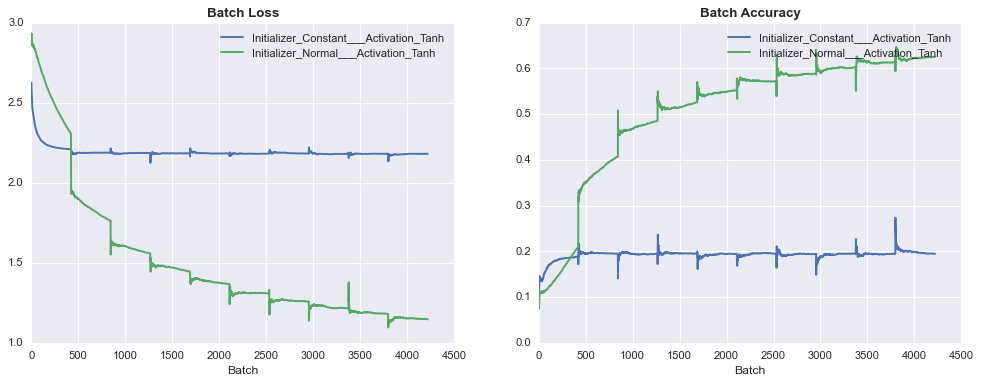

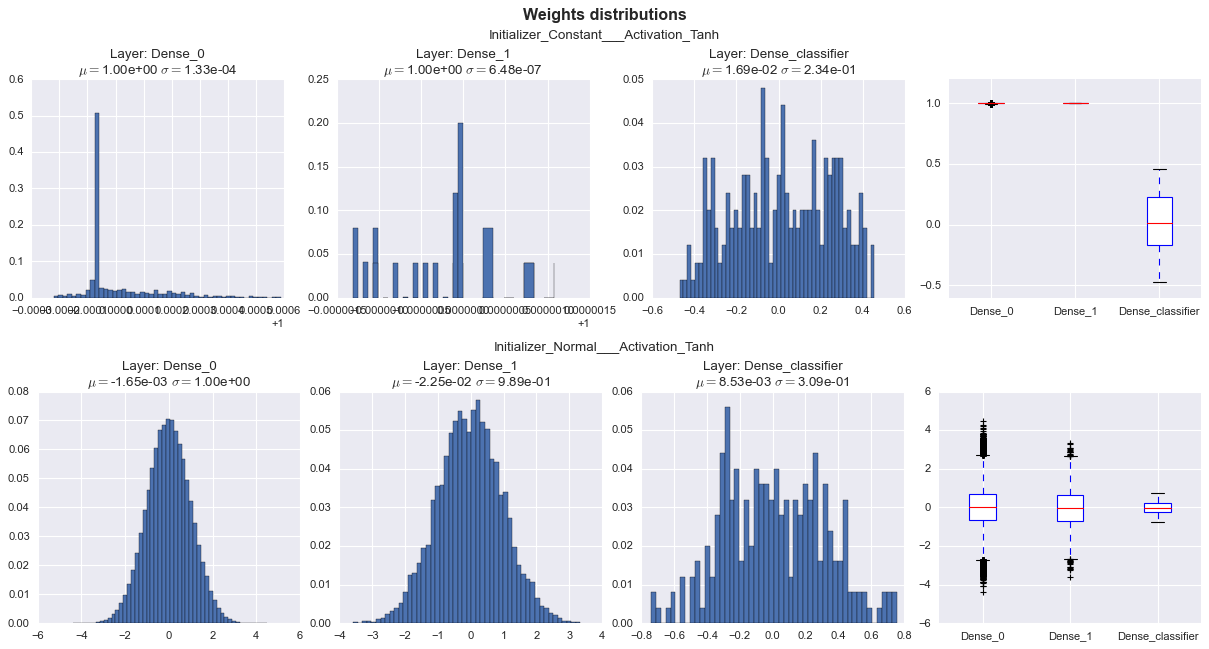

In [13]:
PrintTrainInfo(models[:2])

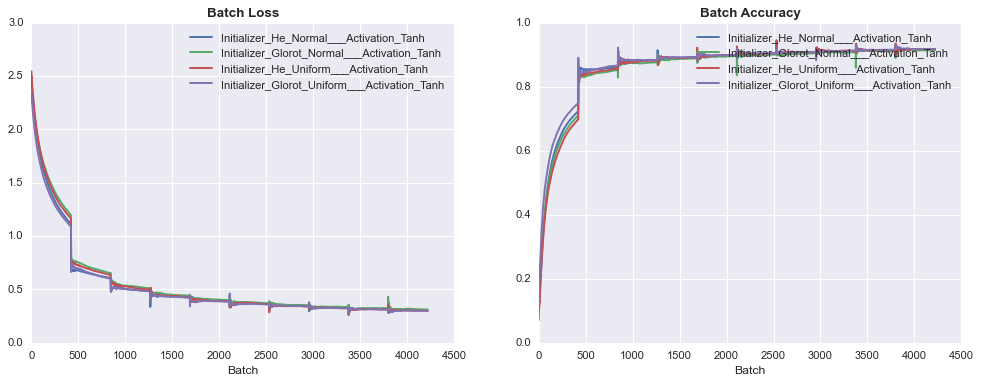

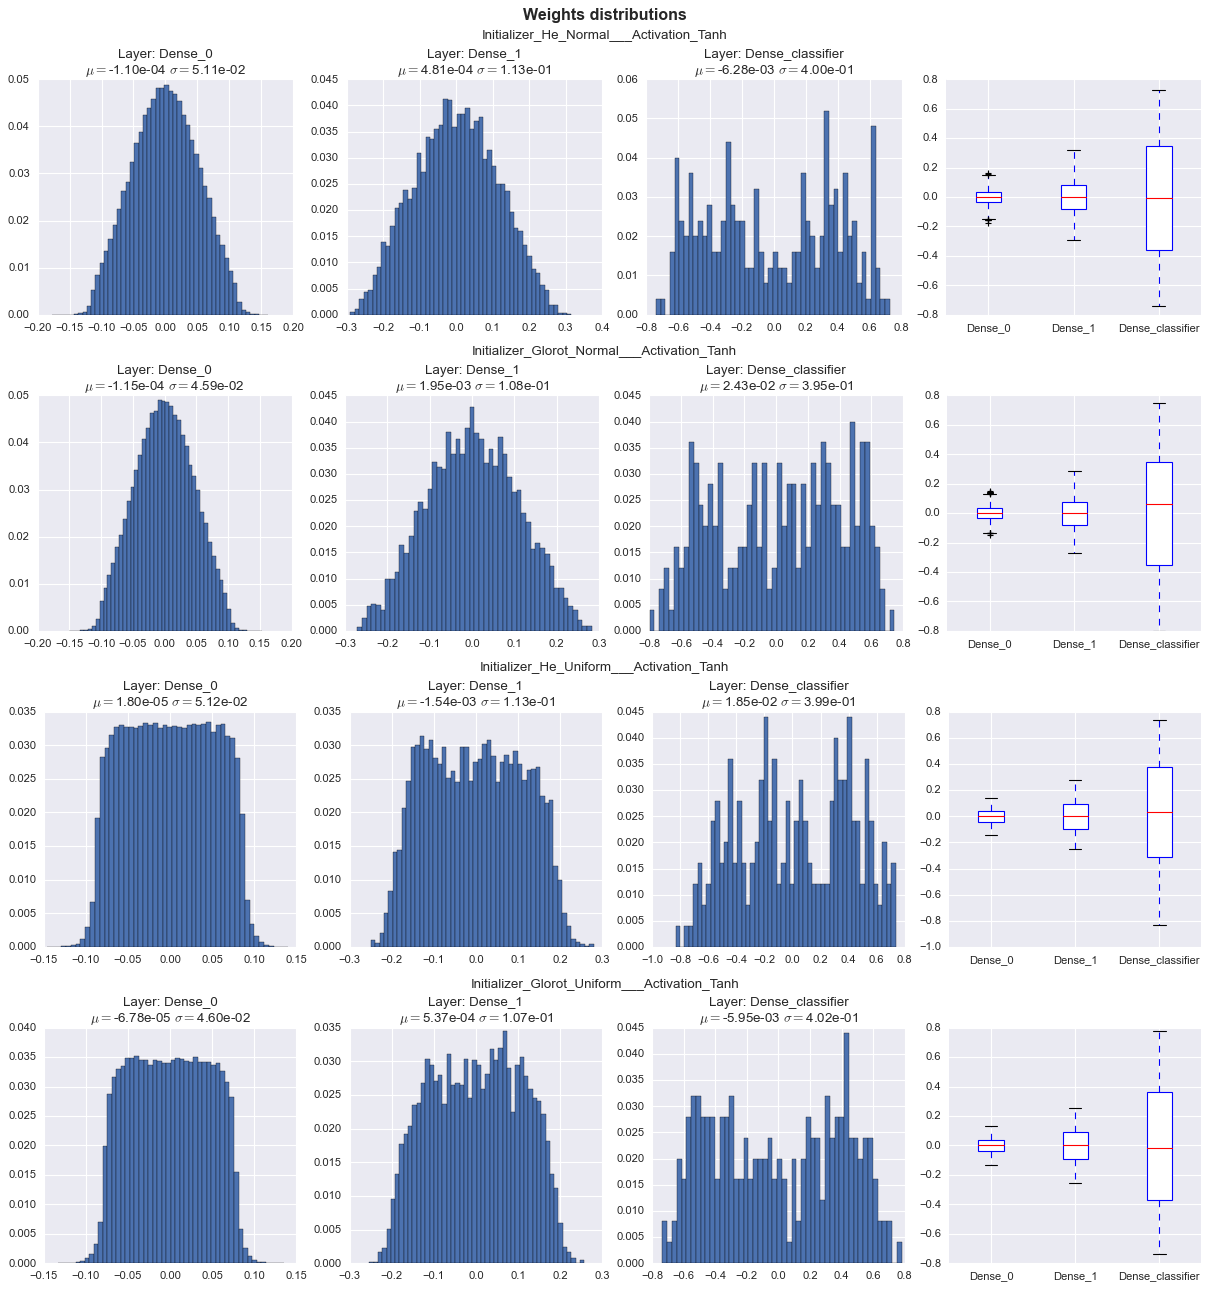

In [14]:
PrintTrainInfo(models[2:6])

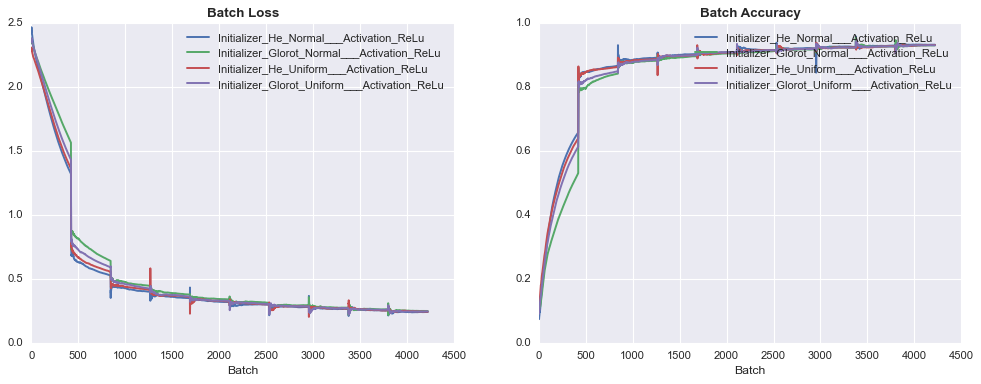

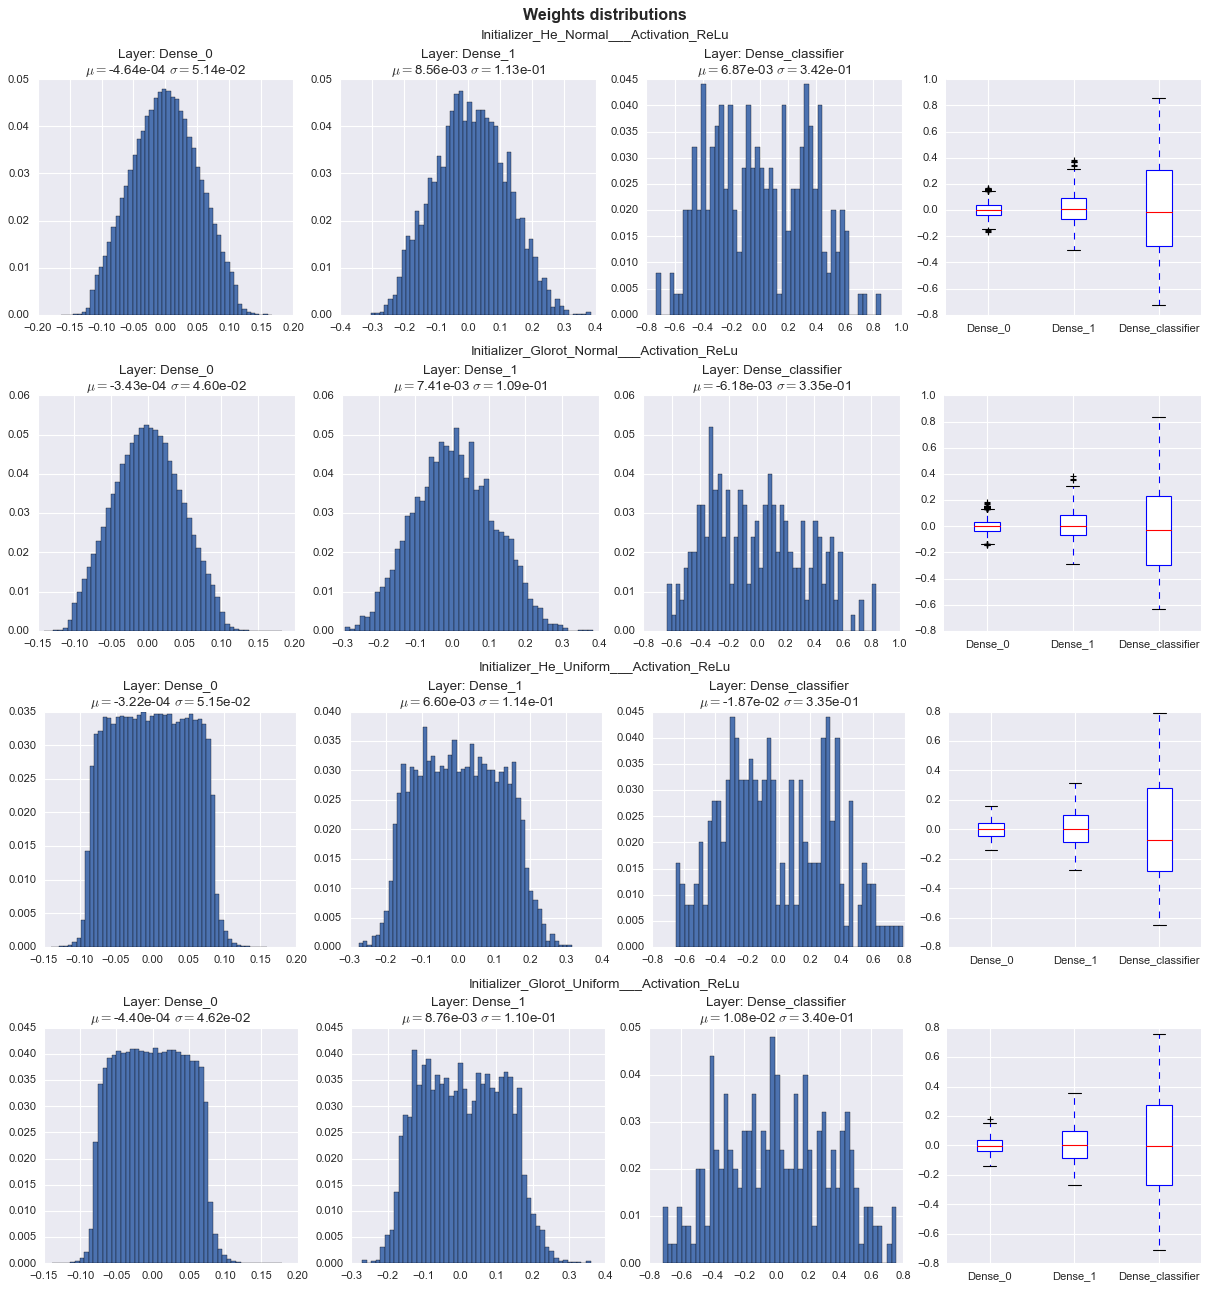

In [15]:
PrintTrainInfo(models[6:])

<hr style="border:1px solid">

Выводы: 
* Использовать случайную инициализацию, т. к. она позволяет избежать проблемы симметрии весов и способствует разнообразию значений весов. При случайной инициализации весов можно использовать равномерное или нормальное распределение.

* Использовать нормализацию весов, т.к. она может помочь в ускорении сходимости алгоритма обучения. Один из способов нормализации весов – это инициализация весов с нулевым средним и небольшой дисперсией. Это позволяет избежать слишком больших или слишком маленьких значений весов, которые могут затруднить обучение.

* Использовать методы, учитывающие размеры слоев, такие как Glorot для симметричных функций активации (или их производных) и He для ReLu подобных функций активации. Размеры слоев нейронной сети могут влиять на статистические особенности выходных данных, а именно на дисперсию. Поэтому для минимизации вклада начального распределения весов в результат работы нейросети и предотвращения проблем возрастающего и умирающего градиентов следует использовать методы, которые могут контролировать данные параметры или помочь вовсе избежать проблемы, связанные с ними.

## Источники

1. [ИТМО](https://neerc.ifmo.ru/wiki/index.php?title=Инициализация_параметров_глубокой_сети)
2. [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
3. [Инициализация Ксавьера Глорота в нейронных сетях — Математическое доказательство](https://coderstudio.ru/articles/652421/)
4. [Delving Deep into Rectifiers:
Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/pdf/1502.01852.pdf)